In [1]:
!apt install -y libsndfile1 ffmpeg
!pip install musdb
!pip install museval
!pip install -q scikit_posthocs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
     |████████████████████████████████| 512kB 13.6MB/s 
     |████████████████████████████████| 92kB 6.7MB/s 
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114212 sha256=153296d5d55b7ad038c9a683e241e7a9bc6cc4dcdef7d11ec26adf62887f9b41
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
Successfully built simplejson


In [2]:
from IPython.display import Audio, display
import urllib.request
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.transforms import BlendedGenericTransform
from urllib.request import urlopen
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scikit_posthocs as sp
import stempeg
import librosa
import librosa.display
import pickle
import tensorflow as tf
import tensorflow.contrib.slim as slim


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
import musdb
mus = musdb.DB(download=True)

Done!


In [0]:
def datagen(data):
  librosa_X=[]
  tracks_orig=[]
  X_abs=[]
  list_length=[]
  for i in range(len(data)):
    track = data[i].audio
    tracks_orig.append(track)
  for i in range(len(tracks_orig)):
    z=librosa.stft(librosa.to_mono(tracks_orig[i].T))
    librosa_X.append(z)
  for i in range(len(librosa_X)):
    X_abs.append(np.abs(librosa_X[i]))
  for i in range(len(librosa_X)):
    stft_len = X_abs[i].shape[0]
    list_length.append(stft_len)
  return tracks_orig, librosa_X, X_abs, list_length

In [0]:
t,l,a,le=datagen(mus[:len(mus)-5])

In [0]:
def targetgen(data,name):
  librosa_targets=[]
  #print(name)
  for i in range(len(data)):
    S =(librosa.stft(librosa.to_mono(data[i].targets[name].audio.T)))
    librosa_targets.append(S)
  return librosa_targets

In [0]:
librosa_vocals=targetgen(mus[:len(mus)-5],'vocals')

In [0]:
librosa_drums=targetgen(mus[:len(mus)-5],'drums')

In [0]:
librosa_bass=targetgen(mus[:len(mus)-5],'bass')

In [0]:
librosa_other=targetgen(mus[:len(mus)-5],'other')

In [0]:
librosa_accompaniment=targetgen(mus[:len(mus)-5],'accompaniment')

In [0]:
librosa_mix=targetgen(mus[:len(mus)-5],'linear_mixture')

In [0]:
def drawspec(data):
  librosa.display.specshow(librosa.amplitude_to_db(np.abs(data), ref=np.max), y_axis='log', x_axis='time')


Text(0.5, 1.0, 'Original file spectogram')

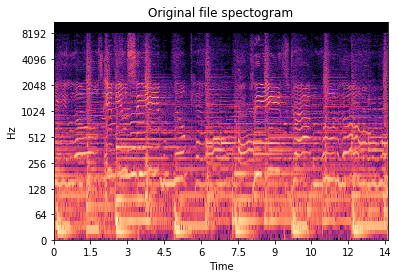

In [14]:
drawspec(a[10])
plt.title("Original file spectogram")

In [0]:
vocal_mask=[]
for i in range(len(librosa_mix)):
  eps = np.finfo(np.float).eps
  model = eps + np.abs(librosa_vocals[i]) + np.abs(librosa_bass[i]+librosa_drums[i]+librosa_other[i])
  Mask_vocals = np.divide(np.abs(librosa_vocals[i]), model)
  vocal_mask.append(Mask_vocals)

Text(0.5, 1.0, 'vocal mask')

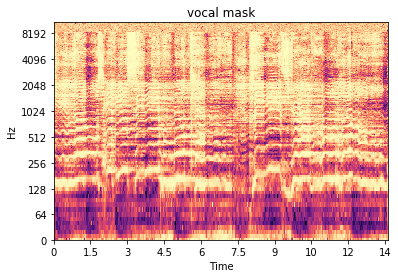

In [16]:
drawspec(vocal_mask[10])
plt.title("vocal mask")

In [0]:
bass_mask=[]
for i in range(len(librosa_mix)):
  eps = np.finfo(np.float).eps
  model = eps + np.abs(librosa_bass[i]) + np.abs(librosa_vocals[i]+librosa_drums[i]+librosa_other[i])
  Mask_bass = np.divide(np.abs(librosa_bass[i]), model)
  bass_mask.append(Mask_bass)

Text(0.5, 1.0, 'Bass mask')

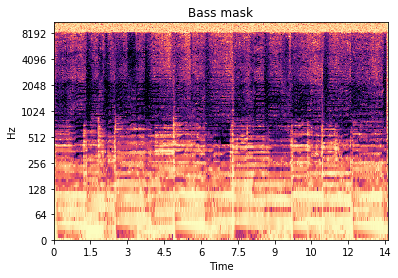

In [18]:
drawspec(bass_mask[10])
plt.title("Bass mask")

In [0]:
drums_mask=[]
for i in range(len(librosa_mix)):
  eps = np.finfo(np.float).eps
  model = eps + np.abs(librosa_drums[i]) + np.abs(librosa_vocals[i]+librosa_bass[i]+librosa_other[i])
  Mask_drums = np.divide(np.abs(librosa_drums[i]), model)
  drums_mask.append(Mask_drums)

Text(0.5, 1.0, 'Drums mask')

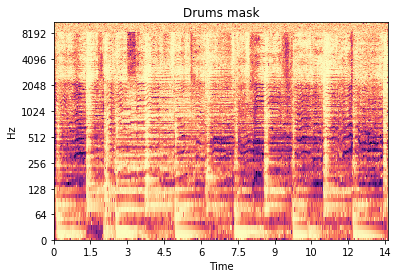

In [20]:
drawspec(drums_mask[10])
plt.title("Drums mask")

In [0]:
other_mask=[]
for i in range(len(librosa_mix)):
  eps = np.finfo(np.float).eps
  model = eps + np.abs(librosa_other[i]) + np.abs(librosa_vocals[i]+librosa_bass[i]+librosa_drums[i])
  Mask_other = np.divide(np.abs(librosa_other[i]), model)
  other_mask.append(Mask_other)

Text(0.5, 1.0, 'Others mask')

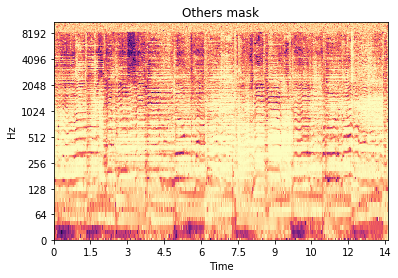

In [22]:
drawspec(other_mask[10])

plt.title("Others mask")

In [0]:
k=other_mask[10]+drums_mask[10]+bass_mask[10]+vocal_mask[10]

In [0]:
tt,lt,at,let=datagen(mus[len(mus)-5:len(mus)])

In [0]:
at=np.asarray(at)

In [0]:
def calc_snr(s,s_pred):
  nlen = min(len(s), len(s_pred))
  return(10*math.log((np.sum(s[:nlen]**2))/(np.sum((s[:nlen] - s_pred[:nlen])**2))))


In [0]:

at1=at.reshape(5,587,1025)

In [0]:
batch_size = 5
tf.reset_default_graph() 
keep_pr = tf.placeholder(tf.float32, ())

In [0]:
frame_size = 1025
num_hidden = 256
max_length = 587
seq_len = tf.placeholder(tf.int32, None)

q2_x = tf.placeholder(tf.float32, [None, max_length, frame_size])
q2_y = tf.placeholder(tf.float32, [None, max_length, frame_size])


In [29]:
#Defining the RNN
output, state = tf.nn.dynamic_rnn(tf.nn.rnn_cell.DropoutWrapper(tf.contrib.rnn.LSTMCell(num_hidden, 
                                                         initializer = tf.contrib.layers.xavier_initializer()),
                                                                output_keep_prob = keep_pr), 
                                  q2_x, dtype=tf.float32, sequence_length=seq_len)


rnn_out = tf.layers.dense(output, 1025, kernel_initializer= tf.contrib.layers.xavier_initializer())
dim = seq_len[0]
fin_out = tf.sigmoid(rnn_out)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)
    

In [31]:
model_summary()

---------
Variables: name (type shape) [size]
---------
rnn/lstm_cell/kernel:0 (float32_ref 1281x1024) [1311744, bytes: 5246976]
rnn/lstm_cell/bias:0 (float32_ref 1024) [1024, bytes: 4096]
dense/kernel:0 (float32_ref 256x1025) [262400, bytes: 1049600]
dense/bias:0 (float32_ref 1025) [1025, bytes: 4100]
Total size of variables: 1576193
Total bytes of variables: 6304772


In [0]:
lr = 0.001
cost = tf.reduce_mean(tf.losses.mean_squared_error(fin_out[:, :dim,:], q2_y[:, :dim, :]))
optimizer = tf.train.AdamOptimizer(learning_rate= lr).minimize(cost)

In [0]:
#Init all TF vars and run the session
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [0]:
epochs = 50
error = np.zeros(epochs)

In [38]:
(np.asarray(a[0:10])).shape

(10, 1025, 587)

In [39]:
#Training the network with shuffling of training batches
for epoch in range(epochs):
    random = np.arange(0, 139, 10)
    np.random.shuffle(random)
    for i in range(len(random)):
        start = int(random[i])
        end = int(start + batch_size)
        epoch_y = np.array(vocal_mask[start:end]).swapaxes(1,2)
        epoch_x = np.array(a[start:end]).swapaxes(1,2)
        seqlen = np.array(le[start:end])
        l, _ = sess.run([cost, optimizer], feed_dict = {q2_x: epoch_x, q2_y: epoch_y, seq_len: seqlen, keep_pr: 1})
        error[epoch] += l
    
    print('Epoch', epoch+1, 'completed out of ', epochs,'; loss: ', error[epoch])

Epoch 1 completed out of  50 ; loss:  1.0471854731440544
Epoch 2 completed out of  50 ; loss:  1.0237406343221664
Epoch 3 completed out of  50 ; loss:  1.0248164869844913
Epoch 4 completed out of  50 ; loss:  1.0001021698117256
Epoch 5 completed out of  50 ; loss:  0.9755758158862591
Epoch 6 completed out of  50 ; loss:  0.9611296057701111
Epoch 7 completed out of  50 ; loss:  0.9604516588151455
Epoch 8 completed out of  50 ; loss:  0.9205265268683434
Epoch 9 completed out of  50 ; loss:  0.9001015350222588
Epoch 10 completed out of  50 ; loss:  0.8806277178227901
Epoch 11 completed out of  50 ; loss:  0.8696274235844612
Epoch 12 completed out of  50 ; loss:  0.8362350054085255
Epoch 13 completed out of  50 ; loss:  0.822196114808321
Epoch 14 completed out of  50 ; loss:  0.810843113809824
Epoch 15 completed out of  50 ; loss:  0.8014486990869045
Epoch 16 completed out of  50 ; loss:  0.7981990873813629
Epoch 17 completed out of  50 ; loss:  0.7806203924119473
Epoch 18 completed out of

In [40]:
saver.save(sess, 'model')

'model'

In [0]:
y_pred=[]
for i in range(5):
    epoch_x = np.zeros((1, a[i].shape[1],a[i].shape[0]))
    epoch_y = np.zeros((1, a[i].shape[1], a[i].shape[0]))
    epoch_x[0,:,:] = at1[i]
    #print(np.array(let[i]))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    TEM_pred= sess.run(fin_out, feed_dict = {q2_x:epoch_x, seq_len : np.array([let[i]]), keep_pr: 1})
    y_pred.append(TEM_pred)


In [42]:
lt[0].shape

(1025, 587)

In [0]:
y_pred1=np.asarray(y_pred).reshape(5,1025,587)

In [44]:
y_pred1[1].shape

(1025, 587)

In [0]:
Y_vocals = np.multiply(lt[4], y_pred1[4])
#Y_vocals1=a[40]
# invert to time domain
vocals_estimate = librosa.istft(Y_vocals)

In [0]:
snr=calc_snr(s,s_pred)

In [0]:
sr=mus[0].rate

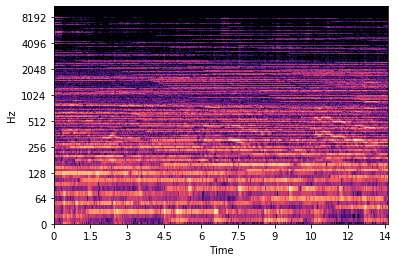

In [47]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y_vocals), ref=np.max), y_axis='log', x_axis='time')
Audio(vocals_estimate, rate=sr)


In [48]:
pop=librosa.istft(lt[4])
Audio(pop, rate=sr)

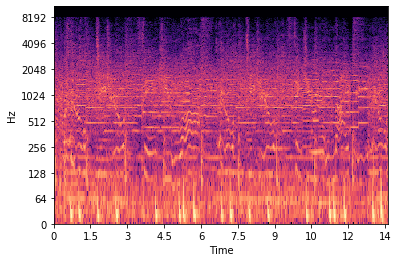

In [49]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(lt[3]), ref=np.max), y_axis='log', x_axis='time')


In [0]:
s=pop
s_pred=vocals_estimate

In [0]:
import math

In [83]:
snr

1.9453814042844384